In [1]:
import os
# Required in order to import xgboost
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.1.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_curve, auc

from scipy import interp

%matplotlib inline

In [2]:
# Read preprocessed dataframes produced in notebook 2_preprocessing.ipynb

x_df = pd.read_csv('x_df.csv')
y_df = pd.read_csv('y_df.csv')

In [3]:
# Define the class weight scale (a hyperparameter) as the ration of negative labels to positive labels.
# This instructs the classifier to address the class imbalance.

class_weight_scale = 1.*y_df.label.value_counts()[0]/y_df.label.value_counts()[1]
class_weight_scale

7.0909090909090908

In [4]:
# Setting minimal required initial hyperparameters

param={
 'objective':'binary:logistic',
 'nthread':4,
 'scale_pos_weight':class_weight_scale
}
xgb1 = XGBClassifier()
xgb1.set_params(**param)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=7.0909090909090908, seed=0, silent=True,
       subsample=1)

class weight scale : 7.09090909091
class weight scale : 7.09090909091
class weight scale : 7.09090909091
class weight scale : 7.09090909091
class weight scale : 7.09090909091


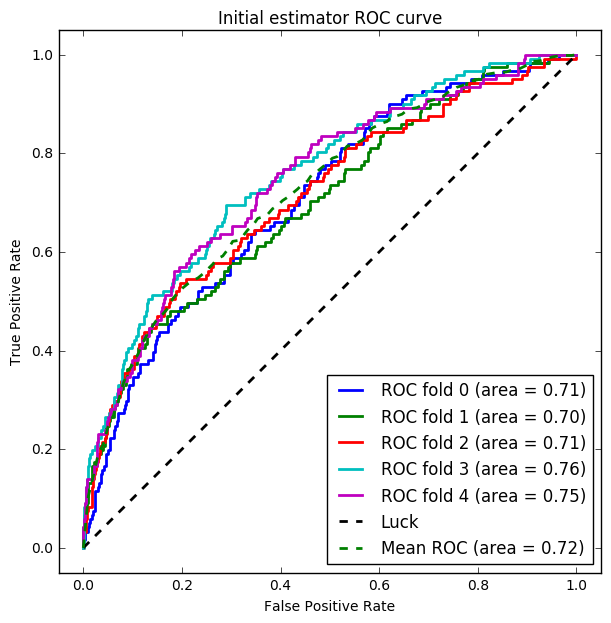

In [5]:
# Train initial classifier and analyze performace using K-fold cross-validation 
K = 5
eval_size = int(np.round(1./K))
skf = StratifiedKFold(n_splits=K)

fig = plt.figure(figsize=(7,7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2
i = 0
roc_aucs_xgb1 = []
for train_indices, test_indices in skf.split(x_df, y_df['label']):
    X_train, y_train = x_df.iloc[train_indices], y_df['label'].iloc[train_indices]
    X_valid, y_valid = x_df.iloc[test_indices], y_df['label'].iloc[test_indices]
    class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
    print 'class weight scale : {}'.format(class_weight_scale)
    xgb1.set_params(**{'scale_pos_weight' : class_weight_scale})
    xgb1.fit(X_train,y_train)
    xgb1_pred_prob = xgb1.predict_proba(X_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, xgb1_pred_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    roc_aucs_xgb1.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= K
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Initial estimator ROC curve')
plt.legend(loc="lower right")

fig.savefig('figures/initial_ROC.png')

In [6]:
# Option to perform hyperparameter optimization. Otherwise loads pre-defined xgb_opt params
optimize = True

In [7]:
X_train = x_df
y_train = y_df['label']

if optimize:
   
    param_test0 = {
     'n_estimators':range(50,250,10)
    }
    print 'performing hyperparamter optimization step 0'
    gsearch0 = GridSearchCV(estimator = xgb1, param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch0.fit(X_train,y_train)
    print gsearch0.best_params_, gsearch0.best_score_

    param_test1 = {
     'max_depth':range(1,10),
     'min_child_weight':range(1,10)
    }
    print 'performing hyperparamter optimization step 1'
    gsearch1 = GridSearchCV(estimator = gsearch0.best_estimator_,
     param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch1.fit(X_train,y_train)
    print gsearch1.best_params_, gsearch1.best_score_

    max_d = gsearch1.best_params_['max_depth']
    min_c = gsearch1.best_params_['min_child_weight']
    
    param_test2 = {
     'gamma':[i/10. for i in range(0,5)]
    }
    print 'performing hyperparamter optimization step 2'
    gsearch2 = GridSearchCV(estimator = gsearch1.best_estimator_, 
     param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch2.fit(X_train,y_train)
    print gsearch2.best_params_, gsearch2.best_score_

    param_test3a = {
        'n_estimators' : range(50, 250, 10)
    }
    print 'performing hyperparamter optimization step 3a'
    gsearch3a = GridSearchCV(estimator = gsearch2.best_estimator_, 
     param_grid = param_test3a, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch3a.fit(X_train,y_train)
    print gsearch3a.best_params_, gsearch3a.best_score_

    param_test3 = {
        'subsample':[i/10.0 for i in range(1,10)],
        'colsample_bytree':[i/10.0 for i in range(1,10)]
    }
    print 'performing hyperparamter optimization step 3'
    gsearch3 = GridSearchCV(estimator = gsearch3a.best_estimator_, 
     param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch3.fit(X_train,y_train)
    print gsearch3.best_params_, gsearch3.best_score_

    param_test4 = {
        'reg_alpha':[0, 1e-5, 1e-3, 0.1, 10]
    }
    print 'performing hyperparamter optimization step 4'
    gsearch4 = GridSearchCV(estimator = gsearch3.best_estimator_, 
     param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch4.fit(X_train,y_train)
    print gsearch4.best_params_, gsearch4.best_score_

    alpha = gsearch4.best_params_['reg_alpha']
    if alpha != 0:
        param_test4b = {
            'reg_alpha':[0.1*alpha, 0.25*alpha, 0.5*alpha, alpha, 2.5*alpha, 5*alpha, 10*alpha]
        }
        print 'performing hyperparamter optimization step 4b'
        gsearch4b = GridSearchCV(estimator = gsearch4.best_estimator_, 
         param_grid = param_test4b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
        gsearch4b.fit(X_train,y_train)
        print gsearch4b.best_params_, gsearch4.best_score_
        print '\nParameter optimization finished!'
        xgb_opt = gsearch4b.best_estimator_
        xgb_opt
    else:
        xgb_opt = gsearch4.best_estimator_
        xgb_opt
else:
    xgb_opt = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.7,
       gamma=0.1, learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=8, missing=None, n_estimators=100, nthread=4,
       objective='binary:logistic', reg_alpha=1e-06, reg_lambda=1,
       scale_pos_weight=7.0909090909090908, seed=1, silent=True,
       subsample=0.6)

performing hyperparamter optimization step 0
{'n_estimators': 70} 0.727532797781
performing hyperparamter optimization step 1
{'max_depth': 3, 'min_child_weight': 5} 0.730875185421
performing hyperparamter optimization step 2
{'gamma': 0.1} 0.732279566164
performing hyperparamter optimization step 3a
{'n_estimators': 70} 0.732279566164
performing hyperparamter optimization step 3
{'subsample': 0.9, 'colsample_bytree': 0.9} 0.736415650465
performing hyperparamter optimization step 4
{'reg_alpha': 10} 0.741356990117
performing hyperparamter optimization step 4b
{'reg_alpha': 25.0} 0.741356990117

Parameter optimization finished!


# K-fold cross-validation

class weight scale : 7.09090909091
class weight scale : 7.09090909091
class weight scale : 7.09090909091
class weight scale : 7.09090909091
class weight scale : 7.09090909091


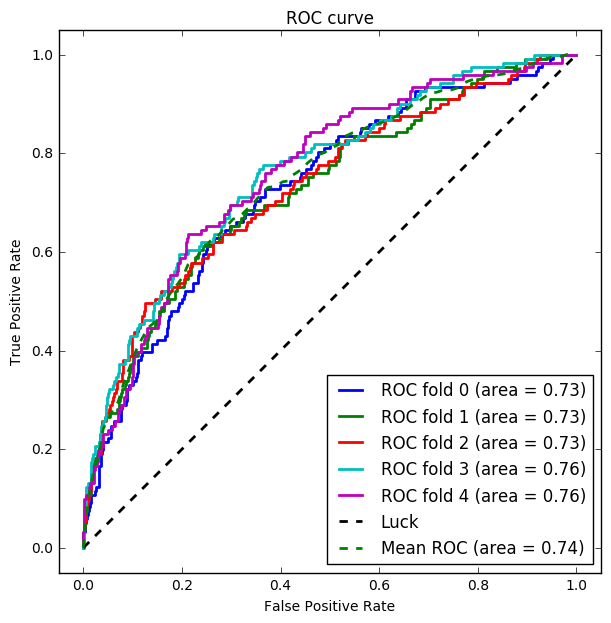

In [8]:
# xgb_opt.set_params(**{'learning_rate' : 0.05})
K = 5
eval_size = int(np.round(1./K))
skf = StratifiedKFold(n_splits=K)


fig = plt.figure(figsize=(7,7))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
lw = 2
i = 0
roc_aucs_xgbopt = []
xgb_opt = gsearch4.best_estimator_
for train_indices, test_indices in skf.split(x_df, y_df['label']):
    X_train, y_train = x_df.iloc[train_indices], y_df['label'].iloc[train_indices]
    X_valid, y_valid = x_df.iloc[test_indices], y_df['label'].iloc[test_indices]
    class_weight_scale = 1.*y_train.value_counts()[0]/y_train.value_counts()[1]
    print 'class weight scale : {}'.format(class_weight_scale)
    xgb_opt.set_params(**{'scale_pos_weight' : class_weight_scale})
    xgb_opt.fit(X_train,y_train)
    xgb_opt_pred_prob = xgb_opt.predict_proba(X_valid)
    fpr, tpr, thresholds = roc_curve(y_valid, xgb_opt_pred_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    roc_aucs_xgbopt.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

    i += 1
    
plt.plot([0, 1], [0, 1], linestyle='--', lw=lw, color='k',
         label='Luck')

mean_tpr /= K
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='g', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")

fig.savefig('figures/ROC.png')

In [9]:
aucs = [np.mean(roc_aucs_xgb1),
        gsearch0.best_score_,
        gsearch1.best_score_,
        gsearch2.best_score_,
        gsearch3a.best_score_,
        gsearch3.best_score_,
        gsearch4.best_score_,
        np.mean(roc_aucs_xgbopt)]

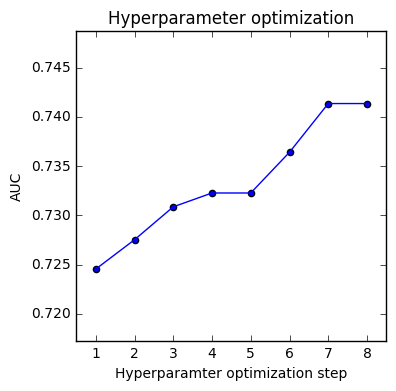

In [15]:
fig = plt.figure(figsize=(4,4))
plt.scatter(np.arange(1,len(aucs)+1), aucs)
plt.plot(np.arange(1,len(aucs)+1), aucs)
plt.xlim([0.5,8.5])
plt.ylim([0.99*aucs[0], 1.01*aucs[-1]])
plt.xlabel('Hyperparamter optimization step')
plt.ylabel('AUC')
plt.title('Hyperparameter optimization')
fig.savefig('figures/optimization.png')

In [22]:
print classification_report(y_true = y_df.label, y_pred = np.zeros(y_df.shape[0]))

             precision    recall  f1-score   support

          0       0.88      1.00      0.93      4290
          1       0.00      0.00      0.00       605

avg / total       0.77      0.88      0.82      4895



In [20]:
print classification_report(y_true = y_df.label, y_pred = xgb_opt.predict(x_df))

             precision    recall  f1-score   support

          0       0.97      0.73      0.83      4290
          1       0.30      0.83      0.44       605

avg / total       0.89      0.74      0.78      4895

